In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time as t
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np
from qiskit.primitives import Estimator
import pickle 

In [2]:
VQE_training =True
n_qubits=4
j_coupling=1
g_coupling=1.5
n_rep_VQEansatz=1

def callback_graph(x,name='loss'):
    #clear_output(wait=True)
    plt.title("Training curve")
    plt.xlabel("Iteration")
    plt.ylabel(name)
    plt.plot(range(len(x)), x,label='ground state energy')
    #plt.show()


In [3]:
def getGoundState(n_qubits=n_qubits,j_coupling=j_coupling,g_coupling=g_coupling,n_rep_VQEansatz=1,nSteps=200
                 ,learning_rate=1e-2):
    h_coupling=j_coupling*g
    qr_VQE = QuantumRegister(n_qubits)
    qc_VQE = QuantumCircuit(qr_VQE)
    ansatz_VQE =  RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz)
    qc_VQE.h(qr_VQE)
    qc_VQE.compose(ansatz_VQE, inplace=True)  
    
    observable = SparsePauliOp.from_list([("X"+"I"*(n_qubits-1) , h_coupling )])
    for i in np.arange(1,n_qubits,1):
        observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-1-i) , -h_coupling )])
    for i in range(n_qubits-1):
        observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(n_qubits-2-i) ,- j_coupling)]))
        
       
    qnn_VQE=EstimatorQNN(
        estimator=Estimator(options={"shots":1e10}),
        circuit=qc_VQE,
        weight_params=ansatz_VQE.parameters,
        observables=observable
        )

    eigenValues=np.linalg.eig(observable.to_matrix())[0]
    eigenValues.sort()

    groundEnergy=eigenValues[0]
    #print("ground state energy =", groundEnergy)
    
    init_weights=np.random.rand(qnn_VQE.num_weights)*2*np.pi
    weights=init_weights
    
    loss=[]
    for i in range(nSteps):
        vev=qnn_VQE.forward([], weights)[0][0]
        input_grad, weight_grad=qnn_VQE.backward([],weights)
        grad=weight_grad[0,0,:]
        weights=weights-learning_rate*grad
        loss.append(vev)

#         if i%1==0:

#             clear_output(wait=True)
#             plt.figure(1)
#             callback_graph(loss)
#             plt.plot(range(len(loss)),groundEnergy*np.ones(len(loss)),label='truth')
#             plt.legend()
#             #plt.yscale('log')
#             plt.show()

    return weights,vev,groundEnergy

Next, prepare a series of ground states and its labels based on the value of |g|

For |g|<1, two-fold degenerate ground state.

For |g|>1, non-degenerate ground state.

In [7]:
if VQE_training:#Obtaining ground state for |g|<1 
    nSteps=100
    step=0.02
    lowGs=np.arange(0,1,step)
    highGs=np.arange(1+step,2.0+step,step)
    w_low=[]
    Egs_estimate_low=[]
    Egs_low=[]
    for g in lowGs:
        for i in range(5):
            weights,Egs_estimate,Egs=getGoundState(g_coupling=g,nSteps=nSteps,learning_rate=1e-1)
            diff=abs(Egs_estimate-Egs)/abs(Egs)

            if diff< 0.02:
                break
                
        print("g = ",g," diff=",diff)
                
        w_low.append(weights)
        Egs_estimate_low.append(Egs_estimate)
        Egs_low.append(Egs)

    print("lowG finished")
    dict_low={"weights": w_low,"E_gs_estimate": Egs_estimate_low,
              "E_gs":Egs_low,"g":lowGs}
    with open('lowG_dict.pkl', 'wb') as f:
        pickle.dump(dict_low, f)


    w_high=[]
    Egs_estimate_high=[]
    Egs_high=[]
    for g in highGs:
        for i in range(5):
            weights,Egs_estimate,Egs=getGoundState(g_coupling=g,nSteps=nSteps,learning_rate=1e-1)
            diff=abs(Egs_estimate-Egs)/abs(Egs)
            if diff< 0.02:
                break
        print("g = ",g," diff=",diff)
        w_high.append(weights)
        Egs_estimate_high.append(Egs_estimate)
        Egs_high.append(Egs)

    dict_high={"weights": w_high,"E_gs_estimate":Egs_estimate_high,
               "E_gs": Egs_high ,"g":highGs}
    with open('highG_dict.pkl', 'wb') as f:
        pickle.dump(dict_high, f)
        
    dataset={'weights':dict_low['weights']+dict_high['weights'], 
         'label': np.concatenate([-1*np.ones(len(dict_low['weights'])),np.ones(len(dict_high['weights']))])
        }
    
    with open('dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)
    

g =  0.0  diff= 0.001322964483281286
g =  0.02  diff= 0.0017115091068854401
g =  0.04  diff= 9.227209688486677e-07
g =  0.06  diff= 7.784761782693303e-05
g =  0.08  diff= 0.0007669738508482793
g =  0.1  diff= 0.0010647321257653264
g =  0.12  diff= 0.0008915423998837023
g =  0.14  diff= 0.00037585679522999935
g =  0.16  diff= 0.0005118382075472629
g =  0.18  diff= 0.0024000476494704433
g =  0.2  diff= 0.0006034576325997059
g =  0.22  diff= 0.0007274122843992965
g =  0.24  diff= 0.0010165071737687468
g =  0.26  diff= 0.001375443167567808
g =  0.28  diff= 0.0030972244665465657
g =  0.3  diff= 0.004754107285744052
g =  0.32  diff= 0.003978539838556058
g =  0.34  diff= 0.004785092574058526
g =  0.36  diff= 0.004930262827054327
g =  0.38  diff= 0.005508856862428228
g =  0.4  diff= 0.006824686083348487
g =  0.42  diff= 0.0076850952780549014
g =  0.44  diff= 0.010411310688235866
g =  0.46  diff= 0.015234545486878706
g =  0.48  diff= 0.011701149103625193
g =  0.5  diff= 0.014057203165056134
g =

In [8]:
# with open('lowG_dict.pkl', 'rb') as f:
#     dict_low = pickle.load(f)

# with open('highG_dict.pkl', 'rb') as f:
#     dict_high = pickle.load(f)

with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [9]:
X_train=[]
y_train=[]
X_test=[]
y_test=[]
for i in range(len(dataset['label'])):
    if i % 2 == 0:
        X_train.append(dataset['weights'][i])
        y_train.append(dataset['label'][i])
        
    
    else:
        X_test.append(dataset['weights'][i])
        y_test.append(dataset['label'][i])
        
#     if i > int(len(dataset['label'])/2):
#         break
    
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [10]:
def addConv(qc,i1,i2,weights):
    # 15 parameters in total
    params_index=0
    #single qubit rotations
    qc.rz(weights[params_index],i1)
    params_index+=1
    qc.ry(weights[params_index],i1)
    params_index+=1
    qc.rx(weights[params_index],i1)
    params_index+=1
    
    qc.rz(weights[params_index],i2)
    params_index+=1
    qc.ry(weights[params_index],i2)
    params_index+=1
    qc.rx(weights[params_index],i2)
    params_index+=1
    
    #two qubits rotations
    qc.rzz(weights[params_index],i1,i2)
    params_index+=1
    qc.ryy(weights[params_index],i1,i2)
    params_index+=1
    qc.rxx(weights[params_index],i1,i2)
    params_index+=1
    
    qc.rz(weights[params_index],i1)
    params_index+=1
    qc.ry(weights[params_index],i1)
    params_index+=1
    qc.rx(weights[params_index],i1)
    params_index+=1
    
    qc.rz(weights[params_index],i2)
    params_index+=1
    qc.ry(weights[params_index],i2)
    params_index+=1
    qc.rx(weights[params_index],i2)
    
    qc.barrier()
    
def addPooling(qc,i1,i2,weights):
    params_index=0
    qc.rz(weights[params_index],i1)
    params_index += 1
    qc.ry(weights[params_index],i1)
    params_index += 1
    qc.rx(weights[params_index],i1)
    params_index += 1
    
    qc.rz(weights[params_index],i2)
    params_index += 1
    qc.ry(weights[params_index],i2)
    params_index += 1
    qc.rx(weights[params_index],i2)

    qc.cx(i1,i2)

    qc.rx(-weights[params_index],i2)
    qc.ry(-weights[params_index-1],i2)
    qc.rz(-weights[params_index-2],i2)

    qc.barrier()

In [11]:
n_layers=1
n_convWeights=15
n_poolingWeights=6
#n_params=n_convWeights*3 +n_poolingWeights*2
n_params=n_convWeights*5 +n_poolingWeights*3
weights = ParameterVector("weight", n_params)
params_index=0
qr = QuantumRegister(n_qubits)
qc = QuantumCircuit(qr)
qc.compose(RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz), inplace=True) 
qc.barrier()


#Convolution layer:

index_start=0
index_end=n_convWeights
weights_conv1=weights[index_start:index_end]
    
for i in np.arange(0,n_qubits-1,1):
#     index_start=i*n_convWeights
#     index_end=(i+1)*n_convWeights
#     weights_conv1=weights[index_start:index_end]
    addConv(qc,i,i+1,weights_conv1)


    
qc.barrier()
#pooling layer:
index_start=index_end
index_end+=n_poolingWeights
weights_pooling1=weights[index_start:index_end]

for i in np.arange(0,int(n_qubits/2),1):
#     index_start=index_end
#     index_end+=n_poolingWeights
#     weights_pooling1=weights[index_start:index_end]
    addPooling(qc,i*2,i*2+1,weights_pooling1)
qc.barrier()


#Convolution layer2:
index_start=index_end
index_end=index_start+n_convWeights
weights_conv2=weights[index_start:index_end]
for i in np.arange(0,int(n_qubits/4),1):
#     index_start=index_end
#     index_end=index_start+n_convWeights
#     weights_conv2=weights[index_start:index_end]
    addConv(qc,i*4+1,i*4+3,weights_conv2)
 

#pooling layer2:
index_start=index_end
index_end+=n_poolingWeights
weights_pooling2=weights[index_start:index_end]
for i in np.arange(0,int(n_qubits/4),1):
#     index_start=index_end
#     index_end+=n_poolingWeights
#     weights_pooling2=weights[index_start:index_end]
    addPooling(qc,i*4+1,i*4+3,weights_pooling2)

qc.barrier()

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


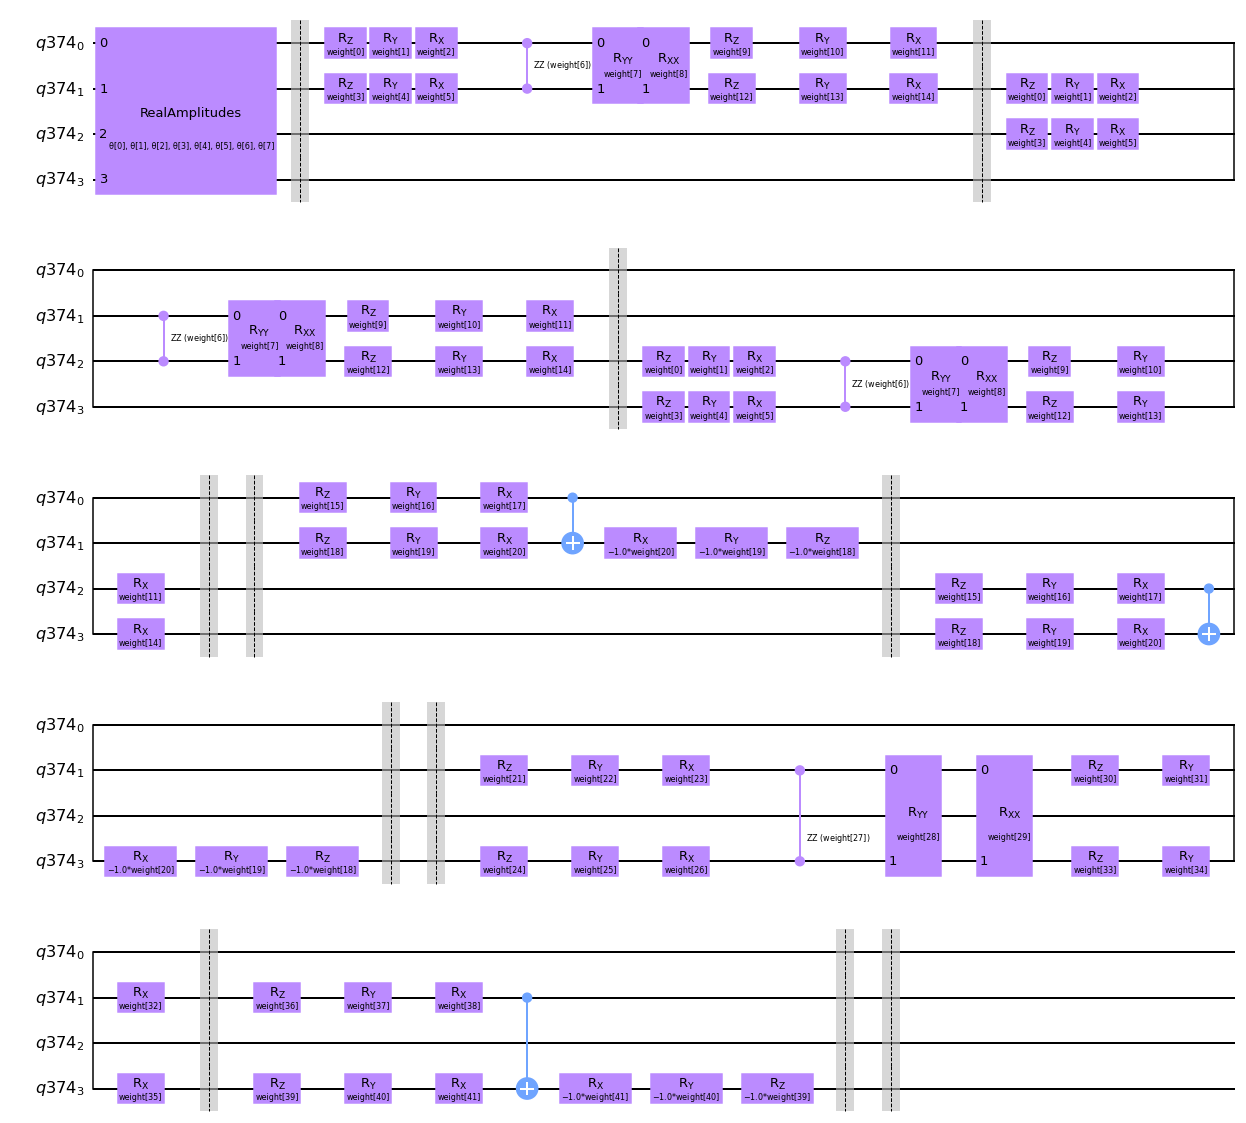

In [12]:
qc.draw('mpl')

In [13]:
def predict(X,qc,ob,weights):

    prediction=[]
    for i in range(len(X)):
        job=estimator.run(circuits=qc, observables=ob
                          , parameter_values=np.concatenate([X[i],weights]))
        jobResult=job.result().values
        prediction.append(jobResult)
    return np.array(prediction).flatten()

In [14]:
def cost_func(weights,X,y,qc,ob):
    global cost_val_list
    pred = predict(X,qc,ob,weights)
    
    #pred=-abs(pred-params[-1])
    cost_val=((pred-y)**2).sum()
    cost_val_list.append(cost_val)
    
    clear_output(wait=True)
    plt.plot(np.arange(0,len(cost_val_list)), cost_val_list)
    plt.xlabel('iteration')
    plt.ylabel('cost function')
    plt.legend()
    plt.show()
    return cost_val

In [15]:
estimator = Estimator()
ob = SparsePauliOp.from_list([("I"*(n_qubits-1)+"Z" , 1 )])
n_VQEparams=len(X_train[0])
n_QCNNweights=qc.num_parameters-n_VQEparams
print(n_VQEparams)
print(n_QCNNweights)

8
42


COBYLA

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


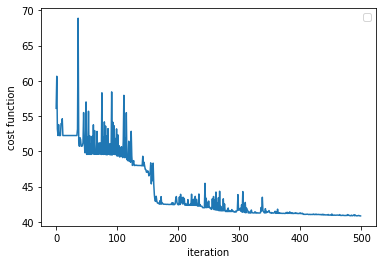

In [16]:
import scipy.optimize 
method='COBYLA'
MaxIter=500
initial_weights=2*np.pi*np.random.rand(n_QCNNweights)
cost_val_list=[]
res = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(X_train,y_train,qc,ob)) #minimize cost function via scipy


0.5 inf
0.52 0.4304827735277928
0.56 0.29159194651995074
0.58 0.2863080166564621
0.7 0.1672679027551689
0.74 0.13669417176593515


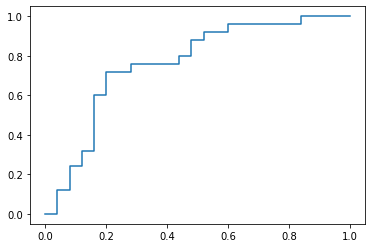

In [17]:

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

y_predict=predict(X_train,qc,ob,res.x)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_predict, pos_label=1)

bestValidation=0
threshold_best=0
for t in thresholds:
    y=y_predict.copy().flatten()
    y[y>t]=1
    y[y<t]=-1
    diff=y-y_train
    val=diff[diff==0].shape[0]/y.shape[0]
    if val>bestValidation:
        bestValidation=val
        threshold_best=t
        print(val,threshold_best)
plt.plot(fpr,tpr)

In [18]:
y_test_predict=predict(X_test,qc,ob,res.x)
y_test_predict[y_test_predict<threshold_best]=-1
y_test_predict[y_test_predict>=threshold_best]=1
diff=y_test-y_test_predict
accuracy_COBYLA=diff[diff==0].shape[0]/diff.shape[0]
print(accuracy_COBYLA)

0.44


Gradient

In [ ]:
def getParamsVariations(x,weights):
    n_VQEparams=len(x)
    #Adding QCNN weight to the VQE parameters to obtain the full list of parameters
    params=np.concatenate([x,weights])
    param_variation_list=[params]
    # vary each weight by +- pi/2 for parameter-shift rule
    for i in range(len(weights)):
        tmp_param=params.copy()
        tmp_param[n_VQEparams+i]+=np.pi/2
        param_variation_list.append(tmp_param)
        tmp_param=params.copy()
        tmp_param[n_VQEparams+i]-=np.pi/2
        param_variation_list.append(tmp_param)
    return np.array(param_variation_list)

def getGrad(jobResult):
    vev=jobResult[0]
    grad=[]
    for i in range(int((jobResult.shape[0]-1)/2)):
        tmpGrad=(jobResult[2*i+1]-jobResult[2*i+2])/2
        grad.append(tmpGrad)
    grad=np.array(grad)
    return vev,grad

In [ ]:
initial_weights=2*np.pi*np.random.rand(n_QCNNweights)
weights=initial_weights

In [ ]:
nIterations=30
learning_rate=1e-1
loss_list=[]

for Iter in range(nIterations):

    cost=0
    grad_all=np.zeros(n_QCNNweights)
    for i in range(len(X_train)):
        param_variation_list=getParamsVariations(X_train[i],weights)
        circuits=[qc]*len(param_variation_list)
        observable=[ob]*len(param_variation_list)
        
        job=estimator.run(circuits=circuits, observables=observable
                          , parameter_values=param_variation_list)
        jobResult=job.result().values
        vev,circuitGrad=getGrad(jobResult)
        cost+=(vev-y_train[i])**2
        grad= 2*(vev-y_train[i])*circuitGrad
        grad_all+=grad
        
    print(cost)
    loss_list.append(cost)
    weights-=learning_rate*grad_all


In [ ]:

y_predict=predict(X_train,qc,ob,weights)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_predict, pos_label=1)

bestValidation=0
threshold_best=0
for t in thresholds:
    y=y_predict.copy().flatten()
    y[y>t]=1
    y[y<t]=-1
    diff=y-y_train
    val=diff[diff==0].shape[0]/y.shape[0]
    if val>bestValidation:
        bestValidation=val
        threshold_best=t
        print(val,threshold_best)
plt.plot(fpr,tpr)

In [ ]:
y_test_predict=predict(X_test,qc,ob,weights)
y_test_predict[y_test_predict<threshold_best]=-1
y_test_predict[y_test_predict>=threshold_best]=1
diff=y_test-y_test_predict
accuracy_Gradient=diff[diff==0].shape[0]/diff.shape[0]
print(accuracy_Gradient)